Nouvelle  version

## Import librairies

In [ ]:
%matplotlib inline

from time import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import make_classification, load_digits
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from yellowbrick.cluster import InterclusterDistance, SilhouetteVisualizer, KElbowVisualizer


pd.set_option("display.max_columns", None)

## Load the dataset

We will start by loading the digits dataset. This dataset contains handwritten digits from 0 to 9. In the context of clustering, one would like to group images such that the handwritten digits on the image are the same.

In [ ]:
load_digits?

In [ ]:
digits = load_digits()  # Dimensionality: 64 features

X, labels = digits.data, digits.target
images = digits.images

# column name for 64
column_names = [f"X{i}" for i in range(64)]

data = pd.DataFrame(X, columns=column_names).assign(label=labels)

(n_samples, n_features), n_digits = X.shape, np.unique(labels).size

print(f"# digits: {n_digits}; # samples: {n_samples}; # features {n_features}")

# digits: 10; # samples: 1797; # features 64


In [ ]:
data

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50,X51,X52,X53,X54,X55,X56,X57,X58,X59,X60,X61,X62,X63,label
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,13.0,15.0,10.0,15.0,5.0,0.0,0.0,3.0,15.0,2.0,0.0,11.0,8.0,0.0,0.0,4.0,12.0,0.0,0.0,8.0,8.0,0.0,0.0,5.0,8.0,0.0,0.0,9.0,8.0,0.0,0.0,4.0,11.0,0.0,1.0,12.0,7.0,0.0,0.0,2.0,14.0,5.0,10.0,12.0,0.0,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,0.0,11.0,16.0,9.0,0.0,0.0,0.0,0.0,3.0,15.0,16.0,6.0,0.0,0.0,0.0,7.0,15.0,16.0,16.0,2.0,0.0,0.0,0.0,0.0,1.0,16.0,16.0,3.0,0.0,0.0,0.0,0.0,1.0,16.0,16.0,6.0,0.0,0.0,0.0,0.0,1.0,16.0,16.0,6.0,0.0,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0,1
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,3.0,16.0,15.0,14.0,0.0,0.0,0.0,0.0,8.0,13.0,8.0,16.0,0.0,0.0,0.0,0.0,1.0,6.0,15.0,11.0,0.0,0.0,0.0,1.0,8.0,13.0,15.0,1.0,0.0,0.0,0.0,9.0,16.0,16.0,5.0,0.0,0.0,0.0,0.0,3.0,13.0,16.0,16.0,11.0,5.0,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0,2
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,13.0,6.0,15.0,4.0,0.0,0.0,0.0,2.0,1.0,13.0,13.0,0.0,0.0,0.0,0.0,0.0,2.0,15.0,11.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,12.0,12.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,10.0,8.0,0.0,0.0,0.0,8.0,4.0,5.0,14.0,9.0,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0,3
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,8.0,0.0,0.0,0.0,0.0,0.0,1.0,13.0,6.0,2.0,2.0,0.0,0.0,0.0,7.0,15.0,0.0,9.0,8.0,0.0,0.0,5.0,16.0,10.0,0.0,16.0,6.0,0.0,0.0,4.0,15.0,16.0,13.0,16.0,1.0,0.0,0.0,0.0,0.0,3.0,15.0,10.0,0.0,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1792,0.0,0.0,4.0,10.0,13.0,6.0,0.0,0.0,0.0,1.0,16.0,14.0,12.0,16.0,3.0,0.0,0.0,4.0,16.0,6.0,3.0,16.0,4.0,0.0,0.0,0.0,12.0,16.0,16.0,16.0,5.0,0.0,0.0,0.0,0.0,4.0,4.0,16.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,5.0,0.0,0.0,0.0,5.0,7.0,7.0,16.0,4.0,0.0,0.0,0.0,2.0,14.0,15.0,9.0,0.0,0.0,9
1793,0.0,0.0,6.0,16.0,13.0,11.0,1.0,0.0,0.0,0.0,16.0,15.0,12.0,16.0,1.0,0.0,0.0,3.0,16.0,7.0,0.0,13.0,6.0,0.0,0.0,4.0,16.0,0.0,0.0,10.0,8.0,0.0,0.0,8.0,16.0,0.0,0.0,14.0,6.0,0.0,0.0,5.0,16.0,7.0,9.0,16.0,5.0,0.0,0.0,1.0,15.0,16.0,16.0,16.0,1.0,0.0,0.0,0.0,6.0,16.0,14.0,6.0,0.0,0.0,0
1794,0.0,0.0,1.0,11.0,15.0,1.0,0.0,0.0,0.0,0.0,13.0,16.0,8.0,2.0,1.0,0.0,0.0,0.0,16.0,15.0,10.0,16.0,5.0,0.0,0.0,0.0,8.0,16.0,16.0,7.0,0.0,0.0,0.0,0.0,9.0,16.0,16.0,4.0,0.0,0.0,0.0,0.0,16.0,14.0,16.0,15.0,0.0,0.0,0.0,0.0,15.0,15.0,15.0,16.0,0.0,0.0,0.0,0.0,2.0,9.0,13.0,6.0,0.0,0.0,8
1795,0.0,0.0,2.0,10.0,7.0,0.0,0.0,0.0,0.0,0.0,14.0,16.0,16.0,15.0,1.0,0.0,0.0,4.0,16.0,7.0,3.0,16.0,7.0,0.0,0.0,5.0,16.0,10.0,7.0,16.0,4.0,0.0,0.0,0.0,5.0,14.0,14.0,16.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,2.0,0.0,0.0,0.0,4.0,7.0,7.0,16.0,2.0,0.0,0.0,0.0,5.0,12.0,16.0,12.0,0.0,0.0,9


label : les différents chiffres

les images sont de taille 8*8. On prend chaque pixel (donc 64 pixels #chaque Xi représente un point d'une image ; X0-X63)  

les Xi (scalés dans 0-16 #au départ 0-255); la valeur du pixel est proportionnelle à la couleur. Par exemple, noir = 0)

Si les images n'étaient pas de même taille (8*8), il aurait fallu faire du resizing.

## EDA

<ipython-input-3-5a6f7f88c0c3>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=data, palette='tab10')


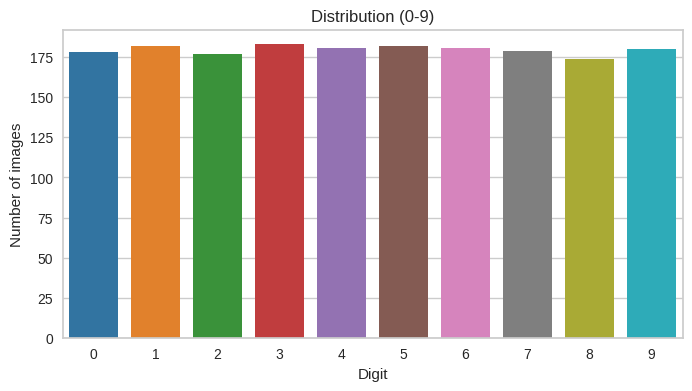

In [ ]:
plt.figure(figsize=(8, 4))
sns.countplot(x='label', data=data, palette='tab10')

plt.title("Distribution (0-9)")
plt.xlabel("Digit")
plt.ylabel("Number of images")
plt.show()

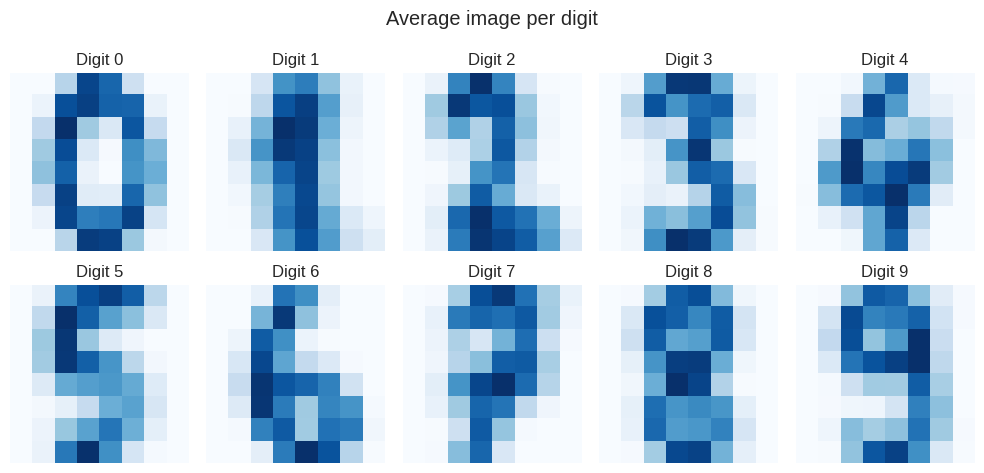

In [ ]:
# mean by digit
mean_images = np.zeros((10, 64))  # 64 pixels #matrice vide 64*
for i in range(10):
    mean_images[i] = data.loc[data.label == i, column_names].mean(axis=0)


fig, axs = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axs.flat):
    ax.imshow(mean_images[i].reshape(8, 8), cmap='Blues') # cmap = gray
    ax.set_title(f"Digit {i}")
    ax.axis('off')
plt.suptitle("Average image per digit")
plt.tight_layout()
plt.show()

On a généré les images moyennes : par calcul de la moyenne des écarts

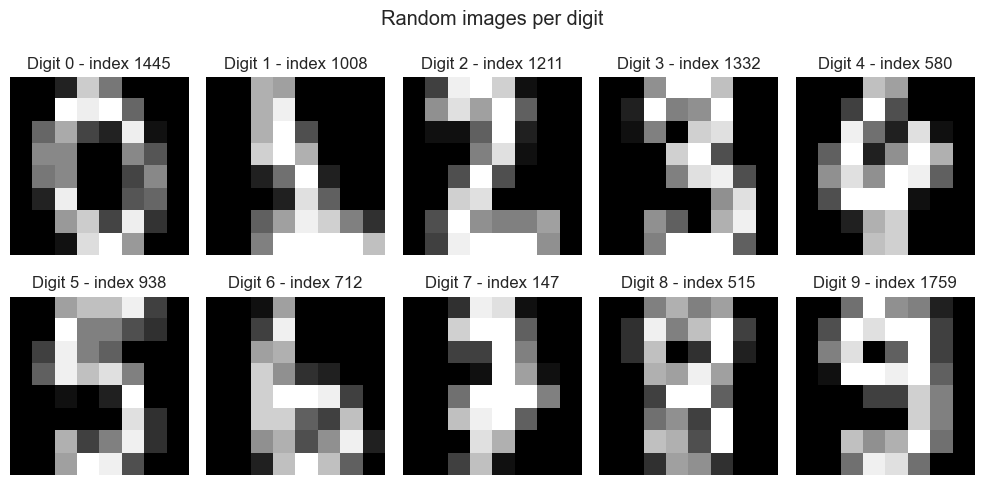

In [ ]:
fig, axs = plt.subplots(2, 5, figsize=(10, 5))
plt.subplots_adjust(left=0.01, right=0.99, bottom=0.01, top=0.91, hspace=0.5)

for i, label in enumerate(np.unique(labels)):
    ax = axs[i // 5, i % 5]
    # Random choice by digit
    idx = np.random.choice(np.where(labels == label)[0])
    ax.imshow(images[idx], cmap='gray')
    ax.set_title(f"Digit {label} - index {idx}")
    ax.axis('off')

plt.suptitle("Random images per digit")
plt.tight_layout()
plt.show();

## Define our evaluation benchmark

We will first our evaluation benchmark. During this benchmark, we intend to compare different initialization methods for KMeans. Our benchmark will:

create a pipeline which will scale the data using a StandardScaler;

train and time the pipeline fitting;

measure the performance of the clustering obtained via different metrics.


In [ ]:
def bench_k_means(kmeans, name, data, labels):
    """Benchmark to evaluate the KMeans initialization methods.

    Parameters
    ----------
    kmeans : KMeans instance
        A :class:`~sklearn.cluster.KMeans` instance with the initialization
        already set.
    name : str
        Name given to the strategy. It will be used to show the results in a
        table.
    data : ndarray of shape (n_samples, n_features)
        The data to cluster.
    labels : ndarray of shape (n_samples,)
        The labels used to compute the clustering metrics which requires some
        supervision.
    """
    t0 = time()
    estimator = make_pipeline(MinMaxScaler(), kmeans).fit(data)
    fit_time = time() - t0 # temps de fitting
    results = [name, fit_time, estimator[-1].inertia_]

    # Define the metrics which require only the true labels and estimator
    # labels
    clustering_metrics = [
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
        metrics.adjusted_rand_score,
    ]
    results += [m(labels, estimator[-1].labels_) for m in clustering_metrics]

    # The silhouette score requires the full dataset
    results += [
        metrics.silhouette_score(
            data,
            estimator[-1].labels_,
            metric="euclidean",
            sample_size=300, #silhouette seulement sur 300 individus mais on peut le faire sur les 1797 individus
        )
    ]


    # Show the results
    formatter_result = (
        "{:9s}\t{:.3f}s\t{:.0f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}"
    )
    print(formatter_result.format(*results))

toujours scaler les données (minmax, standard),

### Run benchmark

In [ ]:
print(82 * "_")
print("init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tsilhouette")

kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=4, random_state=0) #n_digits = 10
#n_init : nombre de fois que K-means va initialiser les centroides, puis faire la moyenne des centroides trouvés pour
bench_k_means(kmeans=kmeans, name="k-means++", data=X, labels=labels)

kmeans = KMeans(init="random", n_clusters=n_digits, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="random", data=X, labels=labels)

pca = PCA(n_components=0.99).fit(X)  # .99).fit(X) je veux 99% de l'info initiale après une ACP
kmeans = KMeans(# init=pca.components_, #on utilise comme centroids de départ les PCA
                n_clusters=n_digits, n_init=20) #si on augmente le nombre d'itération, on a des performances stables qui ne changent plus avec compilation
bench_k_means(kmeans=kmeans, name="PCA-based",
              data=X,
              labels=labels)

print(82 * "_")

print(f"PCA n components: {pca.n_components_}") #nombre de composantes principales après ACP

__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	silhouette
k-means++	0.070s	4647	0.739	0.747	0.743	0.669	0.191
random   	0.062s	4648	0.735	0.742	0.738	0.667	0.175
PCA-based	0.412s	1296	0.729	0.735	0.732	0.637	0.160
__________________________________________________________________________________
PCA n components: 41


In [ ]:
print(82 * "_")
print("init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tsilhouette")

kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=4, random_state=0) #n_digits = 10
bench_k_means(kmeans=kmeans, name="k-means++", data=X, labels=labels)

kmeans = KMeans(init="random", n_clusters=n_digits, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="random", data=X, labels=labels)

pca = PCA(n_components=0.99).fit(X)
kmeans = KMeans(init="k-means++", #on a init avec k-means pour amélioration des performances
                n_clusters=n_digits, n_init=10)
bench_k_means(kmeans=kmeans, name="PCA-based",
              data=pca.transform(X), #c'était d'abord data = X
              labels=labels)

print(82 * "_")

print(f"PCA n components: {pca.n_components_}") #nombre de composantes principales après ACP

__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	silhouette
k-means++	0.069s	4647	0.739	0.747	0.743	0.669	0.175
random   	0.063s	4648	0.735	0.742	0.738	0.667	0.187
PCA-based	0.162s	1297	0.779	0.780	0.780	0.709	0.176
__________________________________________________________________________________
PCA n components: 41


comment utiliser la PCA avec k-means ?

trouver le nombre de colonnes à utiliser sur les 64 (les composantes)

valeurs de silhouettes très faible, ARI métrique principale

In [ ]:
X_pca=pca.transform(X)

In [ ]:
pca = PCA(n_components=0.95).fit(X).n_components

0.95

## Optimal number of clusters

In [ ]:
scaler = MinMaxScaler()  # StandardScaler()
X_scaled = scaler.fit_transform(X)

### Elbow method

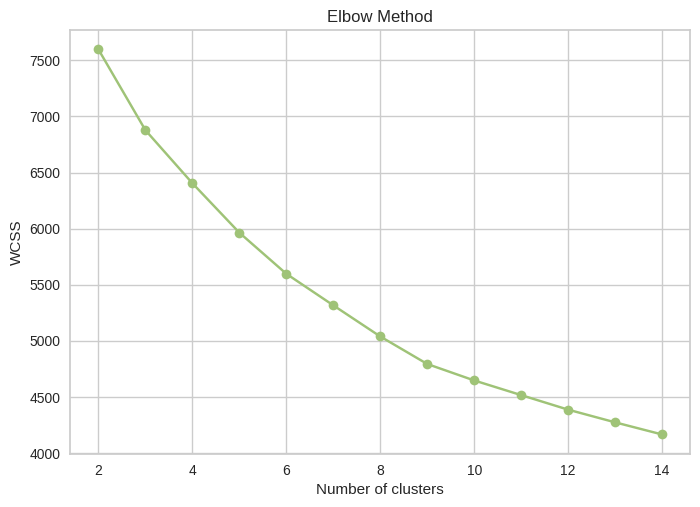

In [ ]:
wcss = []  # Within-Cluster Sum of Squares : variance intra-groupes

k_grid = range(2, 15)
for i in k_grid:
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(k_grid, wcss, 'go-')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

chercher avec 8,9,10,11

### Yellow brick lib

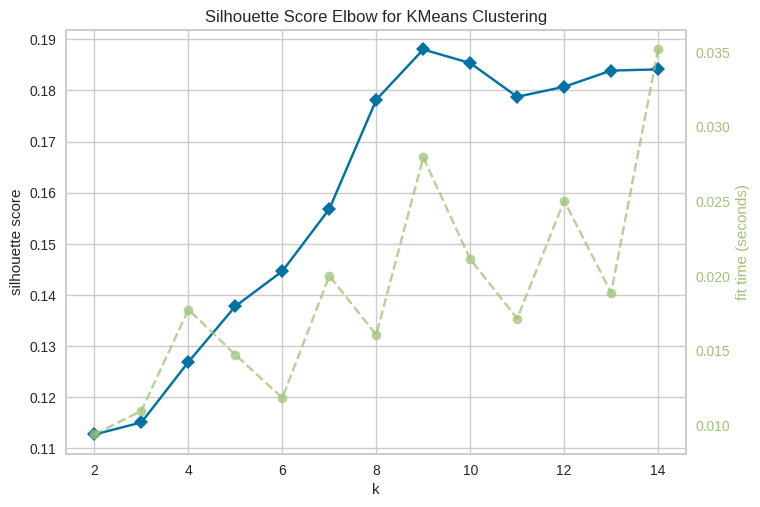

In [ ]:
# Instantiate the clustering model and visualizer

# - **distortion**: mean sum of squared distances to centers
# - **silhouette**: mean ratio of intra-cluster and nearest-cluster distance
# - **calinski_harabasz**: ratio of within to between cluster dispersion


visualizer = KElbowVisualizer(KMeans(),
                              metric='silhouette',  # possible values: calinski_harabasz, distortion, silhouette
                              distance_metric="euclidean", # options allowed by sklearn's metrics.pairwise.pairwise_distances
                              k=k_grid,
                              timings=True,
                              locate_elbow=False, # True or False
                             )

visualizer.fit(X_scaled)        # Fit the data to the visualizer
visualizer.show();       # Finalize and render the figure

A 9 clusters on a le silhouette score maximal, 10 aussi c'est pas mal.

Pourquoi ça ne donne pas 10 clusters ?

## Visualize the results on PCA-reduced data


### Profiling: cluster persona

In [ ]:
reduced_data = PCA(n_components=2).fit_transform(X)
kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=4)
kmeans.fit(reduced_data)

kmean_labels = kmeans.labels_

In [ ]:
data["cluster"] = kmean_labels
data.head()

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50,X51,X52,X53,X54,X55,X56,X57,X58,X59,X60,X61,X62,X63,label,cluster
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,13.0,15.0,10.0,15.0,5.0,0.0,0.0,3.0,15.0,2.0,0.0,11.0,8.0,0.0,0.0,4.0,12.0,0.0,0.0,8.0,8.0,0.0,0.0,5.0,8.0,0.0,0.0,9.0,8.0,0.0,0.0,4.0,11.0,0.0,1.0,12.0,7.0,0.0,0.0,2.0,14.0,5.0,10.0,12.0,0.0,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0,0,6
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,0.0,11.0,16.0,9.0,0.0,0.0,0.0,0.0,3.0,15.0,16.0,6.0,0.0,0.0,0.0,7.0,15.0,16.0,16.0,2.0,0.0,0.0,0.0,0.0,1.0,16.0,16.0,3.0,0.0,0.0,0.0,0.0,1.0,16.0,16.0,6.0,0.0,0.0,0.0,0.0,1.0,16.0,16.0,6.0,0.0,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0,1,9
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,3.0,16.0,15.0,14.0,0.0,0.0,0.0,0.0,8.0,13.0,8.0,16.0,0.0,0.0,0.0,0.0,1.0,6.0,15.0,11.0,0.0,0.0,0.0,1.0,8.0,13.0,15.0,1.0,0.0,0.0,0.0,9.0,16.0,16.0,5.0,0.0,0.0,0.0,0.0,3.0,13.0,16.0,16.0,11.0,5.0,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0,2,7
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,13.0,6.0,15.0,4.0,0.0,0.0,0.0,2.0,1.0,13.0,13.0,0.0,0.0,0.0,0.0,0.0,2.0,15.0,11.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,12.0,12.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,10.0,8.0,0.0,0.0,0.0,8.0,4.0,5.0,14.0,9.0,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0,3,3
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,8.0,0.0,0.0,0.0,0.0,0.0,1.0,13.0,6.0,2.0,2.0,0.0,0.0,0.0,7.0,15.0,0.0,9.0,8.0,0.0,0.0,5.0,16.0,10.0,0.0,16.0,6.0,0.0,0.0,4.0,15.0,16.0,13.0,16.0,1.0,0.0,0.0,0.0,0.0,3.0,15.0,10.0,0.0,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0,4,5


In [ ]:
# Mapping cluster => label
contingency_table = pd.crosstab(data["cluster"], data["label"])
contingency_table

# 117 représente le nombre d'images dont le label est 7 donc le cluster 0 c'est pour le label 7

label,0,1,2,3,4,5,6,7,8,9
cluster,,,,,,,,,,
0,0,9,5,12,3,24,0,117,24,9
1,157,0,0,0,0,6,7,0,0,0
2,1,1,0,0,150,2,27,0,1,0
3,0,0,3,97,0,1,0,0,0,13
4,0,89,1,0,7,1,0,23,4,0
5,3,5,4,26,0,43,0,0,3,123
6,15,0,0,0,16,5,145,0,0,1
7,0,0,119,37,0,4,0,1,4,5
8,2,26,32,11,0,42,0,1,69,19


on utilise les index max
on a des silhouette score faibles parce que le modèle a du mal à distinguer 8 et 5

In [ ]:
major_digit = contingency_table.idxmax(axis=1)
print(major_digit)

cluster
0    7
1    0
2    9
3    4
4    8
5    8
6    6
7    3
8    2
9    1
dtype: int64


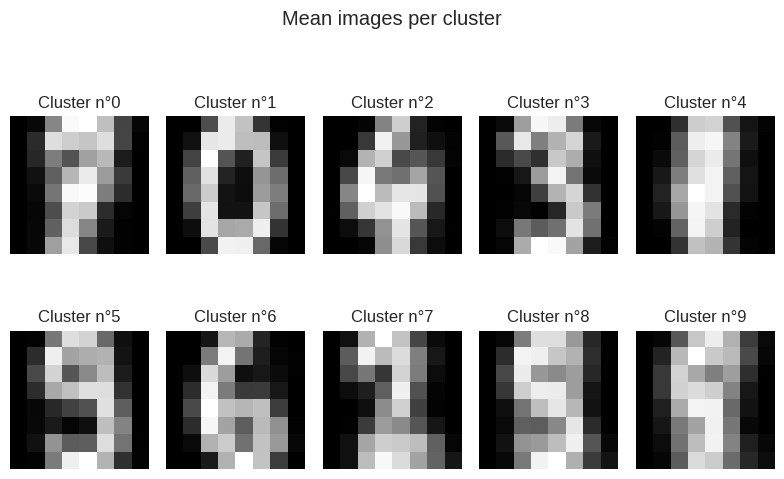

In [ ]:
for cluster_id in range(n_digits):
    cluster_indices = np.where(kmean_labels == cluster_id)
    cluster_images = X[cluster_indices]
    mean_image = cluster_images.mean(axis=0).reshape(8, 8)

    plt.subplot(2, 5, cluster_id + 1)
    plt.imshow(mean_image, cmap='gray')
    plt.title(f"Cluster n°{cluster_id}")
    plt.axis('off')

plt.suptitle("Mean images per cluster")
plt.tight_layout()
plt.show()

### Visualization

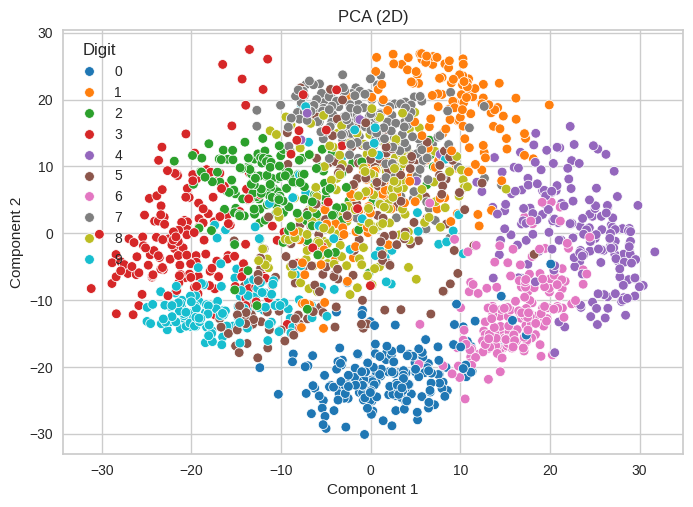

In [ ]:
sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=data.label, palette='tab10', legend='full')
plt.title("PCA (2D)") # visualisation sur les 2 premières composantes
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(title="Digit")
plt.show()


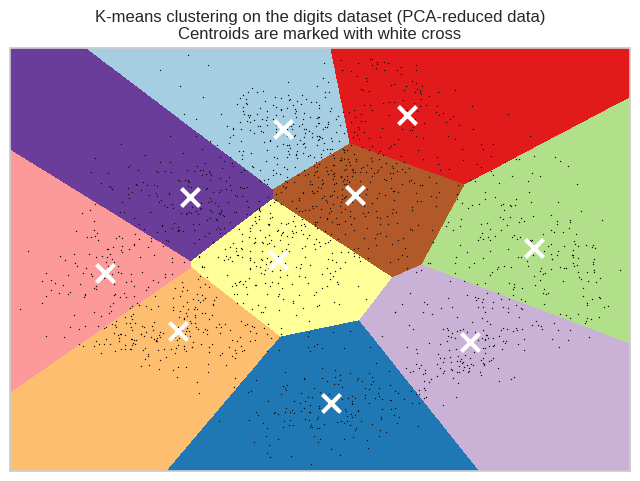

In [ ]:


# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

plt.plot(reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    color="w",
    zorder=10,
)
plt.title(
    "K-means clustering on the digits dataset (PCA-reduced data)\n"
    "Centroids are marked with white cross"
)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(());

## Intercluster Distance Maps

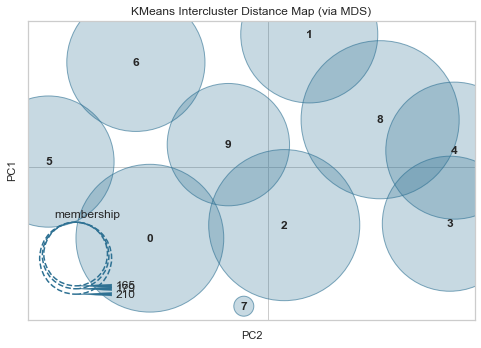

<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [ ]:
# Instantiate the clustering model and visualizer
model = KMeans(10)
visualizer = InterclusterDistance(model)

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

## Visualisation with TSNE

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
# Initialize
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_scaled)

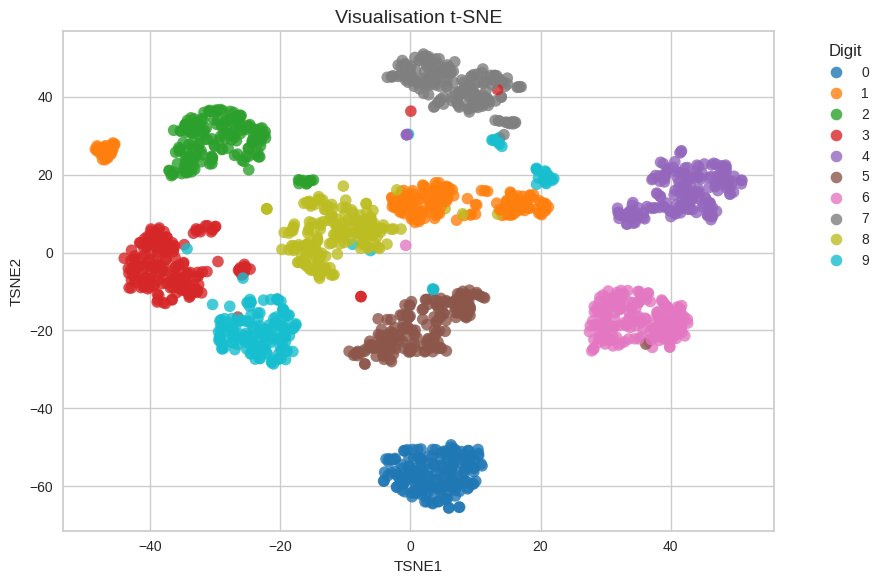

In [ ]:
# code du graphique
df_tsne = pd.DataFrame(X_tsne, columns=['TSNE1', 'TSNE2'])
df_tsne['label'] = labels # Conversion en string pour une discrétisation catégorielle

# Plot
plt.figure(figsize=(9, 6))
sns.scatterplot(
    data=df_tsne,
    x='TSNE1',
    y='TSNE2',
    hue='label',
    palette='tab10',
    alpha=0.8,
    s=70,
    edgecolor='none'
)
plt.title('Visualisation t-SNE', fontsize=14)
plt.legend(title='Digit', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


# **TP :**

optimiser les hyperparamètres du Kmeans avec au moins 3 hyperparamètres y compris le nombre de clusters; avec ou sans PCA.
Visualiser avec ou sans réduction de dimension.

Optimiser la standardisation des variables : voir leurs impacts (robust, standard, minmax)

justifier pourquoi on a choisi tels ou tels paramètres et quelle standardisation (voir les scores) : visualisation avec tsne du meilleur clustering, et éventuellement d'autres graphiques.

Deadline : jeudi prochain 18h00

objet : TP ISE - Clustering 2025

## Optimisation des hyperparamètres de Kmeans

Nous allons optimiser les hyperparamètres nombre de clusters (n_clusters), méthode d'initialisation (init) et n_init du modèle KMeans. En plus des ces hyperparamètres, nous optimiserons également le choix de la méthode de standardisation, l'utilisation de l'ACP. Nous évaluerons tous ces modèles à partir du silhouette score, du ARI, de l'homogénéïté. Ici on maximise le ARI en raison de la présence de vraies labels. Cependant, lorsque le nombre de classes du clustering est différent significativement de 10, le ARI perd de plus en plus en interprétabilité. Pour cette raison, nous testerons les valeurs du nombre de clusters proche de 10 c'est à dire 8, 9, 10, 11 et 12. Le silhouette score nous permettra de juger de la qualité de la classification même en maximisant le ARI. Ce qui signifie dans ce cas que même après maximisation du ARI, nous utiliserons le silhouette score comparativement à ses autres valeurs pour les autres modèles pour juger de la qualité relative de la classification ayant le meilleur ARI par rapport aux autres modèles (en particulier celui ayant le meilleur silhouette score).

Top 5 configurations :
     n_clusters       init  n_init  use_pca        scaler       inertia  \
170          11  k-means++      20    False  MinMaxScaler  4.515184e+03   
48           11  k-means++       5    False          None  1.132058e+06   
50           11  k-means++      20    False          None  1.131795e+06   
49           11  k-means++      10    False          None  1.131795e+06   
52           11     random      10    False          None  1.133372e+06   

     silhouette       ARI  homogeneity  completeness  
170    0.183340  0.739647     0.795169      0.769845  
48     0.183321  0.737691     0.794175      0.769040  
50     0.182963  0.731352     0.788577      0.763972  
49     0.182963  0.731352     0.788577      0.763972  
52     0.184185  0.728517     0.793378      0.767893  


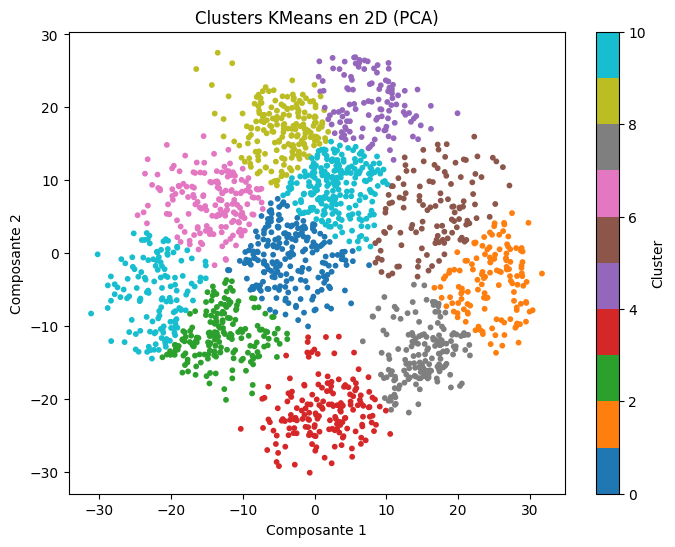

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.pipeline import make_pipeline

from sklearn.metrics import (
    adjusted_rand_score,
    homogeneity_score,
    completeness_score
)

digits = load_digits()
X, y = digits.data, digits.target

def evaluate_kmeans(X, y, use_pca, n_clusters, init, n_init, scaler):
    if use_pca:
        pca = PCA(n_components=0.95)
        X_transformed = pca.fit_transform(X)
    else:
        X_transformed = X

    if scaler:
        pipeline = make_pipeline(scaler, KMeans(
            n_clusters=n_clusters,
            init=init,
            n_init=n_init,
            random_state=0
        ))
    else:
        pipeline = make_pipeline(KMeans(
            n_clusters=n_clusters,
            init=init,
            n_init=n_init,
            random_state=0
        ))

    pipeline.fit(X_transformed)
    labels = pipeline.named_steps['kmeans'].labels_
    inertia = pipeline.named_steps['kmeans'].inertia_
    silhouette = silhouette_score(X_transformed, labels)

    # New metrics
    ari = adjusted_rand_score(y, labels)
    homogeneity = homogeneity_score(y, labels)
    completeness = completeness_score(y, labels)

    return {
        "n_clusters": n_clusters,
        "init": init,
        "n_init": n_init,
        "use_pca": use_pca,
        "scaler": scaler.__class__.__name__ if scaler else "None",
        "inertia": inertia,
        "silhouette": silhouette,
        "ARI": ari,
        "homogeneity": homogeneity,
        "completeness": completeness
    }


results = []

scalers = [None, StandardScaler(), MinMaxScaler(), RobustScaler()]

for scaler in scalers:
  for use_pca in [True, False]:
      for n_clusters in [8, 9, 10, 11, 12]:
          for init in ["k-means++", "random"]:
              for n_init in [5, 10, 20]:
                  res = evaluate_kmeans(X, y, use_pca, n_clusters, init, n_init, scaler)
                  results.append(res)

# Résultats dans un DataFrame
results_df = pd.DataFrame(results)
best = results_df.sort_values(by="ARI", ascending=False).head(5)
print("Top 5 configurations :")
print(best)

best_config = best.iloc[0]
pca_visu = PCA(n_components=2)
X_2d = pca_visu.fit_transform(X)

kmeans_visu = KMeans(
    n_clusters=int(best_config.n_clusters),
    init=best_config.init,
    n_init=int(best_config.n_init),
    random_state=0
)
kmeans_visu.fit(X_2d)
labels_2d = kmeans_visu.labels_

# Visualisation
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels_2d, cmap='tab10', s=10)
plt.title("Clusters KMeans en 2D (PCA)")
plt.xlabel("Composante 1")
plt.ylabel("Composante 2")
plt.colorbar(scatter, label="Cluster")
plt.show()


Le meilleur modèle compte 11 clusters avec initialisation kmeans++, n_init = 20, sans ACP et avec scaler MinMaxScaler. La comparaison aux autres modèles n'a pas été fait dans le code directement mais plutôt implicitement avec des tests personnelles. Cependant il est facile d'obtenir les résultats pour comparaison en regardant le dataframe des résultats de plus près.

Ici, le meilleur est le MinMaxScaler. Cela est dû au fait que les données sont naturellement bornées (0 à 15) ce qui a pour conséquence de conserver l'information en ramenant à 0-1.
Par contre, StandardScaler marche moins bien que MinMaxScaler mais bien mieux que RobustScaler. Cela est dû au fait que le StandardScaler étant plus général, suppose la normalité des données. Ce qui fait qu'il comprend moins bien le fait que les données soient bornées étant donné que la distribution normale ne l'est pas.

Le RobustScaler est adapté à la présence de valeurs aberrantes. Ce qui n'est pas le cas ici vu qu'on a une borne.

In [11]:
# Re-run PCA if needed
if best_config.use_pca:
    pca = PCA(n_components=0.95)
    X_best = pca.fit_transform(X)
else:
    X_best = X

# Re-run scaling if needed
scaler = {
    "StandardScaler": StandardScaler(),
    "MinMaxScaler": MinMaxScaler(),
    "RobustScaler": RobustScaler(),
    "None": None
}[best_config.scaler]

if scaler:
    X_best = scaler.fit_transform(X_best)

kmeans = KMeans(
    n_clusters=int(best_config.n_clusters),
    init=best_config.init,
    n_init=int(best_config.n_init),
    random_state=0
)
kmeans.fit(X_best)
predicted_labels = kmeans.labels_

contingency = pd.crosstab(index=predicted_labels, columns=y,
                          rownames=["Cluster"], colnames=["True Label"])

contingency_percent = contingency.div(contingency.sum(axis=1), axis=0) * 100
contingency_percent = contingency_percent.round(2)

# Step 4: Print the result
print("\nContingency Table (percentages, Clusters as rows):")
print(contingency_percent)



Contingency Table (percentages, Clusters as rows):
True Label      0      1      2      3      4      5      6      7      8  \
Cluster                                                                     
0            0.00   0.00   1.01   3.54   2.53   0.00   0.00  88.38   1.01   
1            0.00   0.00   7.23   4.22   1.81   0.00   0.60   1.81  83.13   
2            0.00   1.10   0.00   0.00   0.00   1.10  97.24   0.00   0.55   
3            0.00   0.66   0.00   1.32   0.00  90.13   0.00   0.00   3.95   
4            0.00  80.65   0.81   0.81   4.03   0.00   2.42   0.81  10.48   
5            0.00   0.00   0.51   3.57   0.00  20.41   0.00   0.00   2.55   
6           98.88   0.00   0.56   0.00   0.00   0.00   0.56   0.00   0.00   
7            0.61   0.00   0.00   0.00  98.18   1.21   0.00   0.00   0.00   
8            0.00   0.57   6.90  90.80   0.00   0.57   0.00   0.00   0.00   
9            0.00  13.79  83.91   0.57   0.00   0.00   0.00   0.00   1.72   
10           0.00  61.36

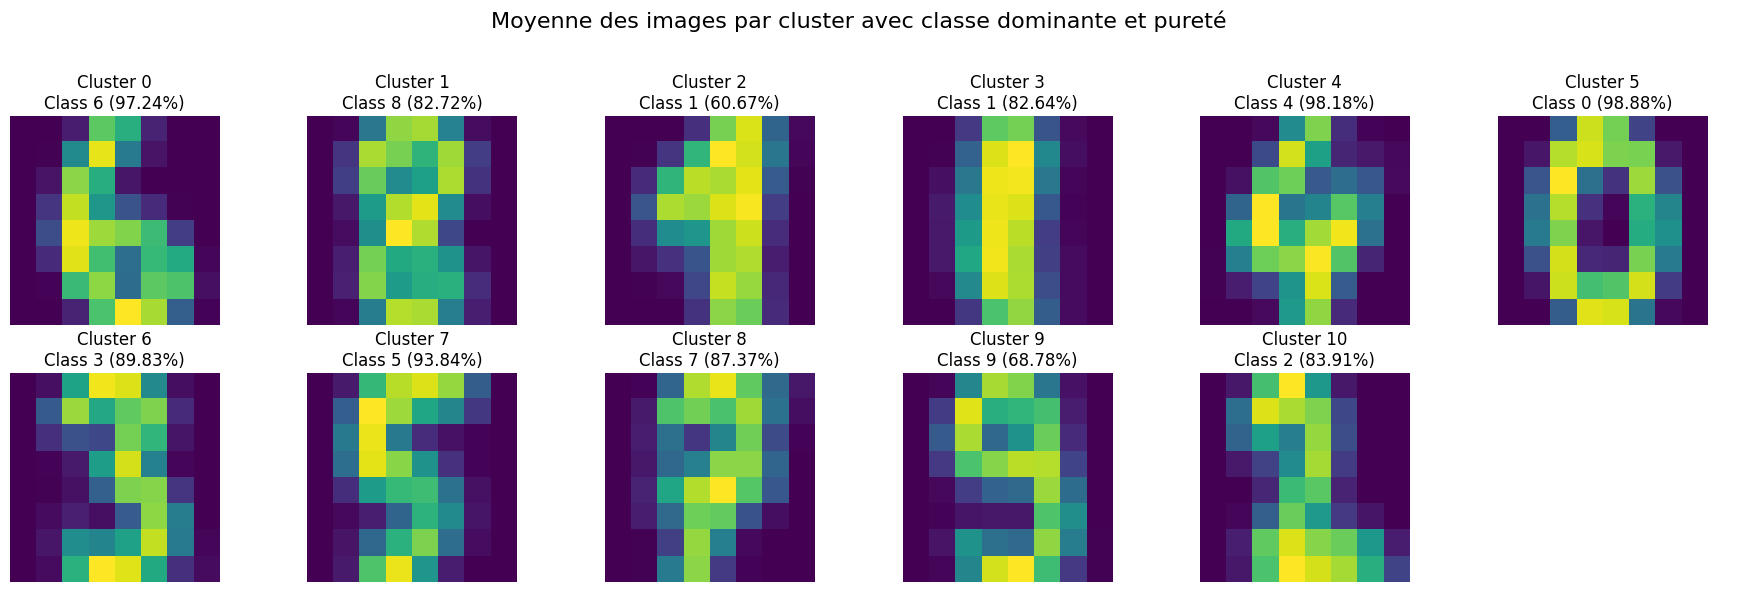

In [17]:
X_input = X.copy()
if best_config.use_pca:
    pca_final = PCA(n_components=0.95)
    X_input = pca_final.fit_transform(X)
    X_recon = pca_final.inverse_transform(X_input)
else:
    X_recon = X_input

final_kmeans = KMeans(
    n_clusters=int(best_config.n_clusters),
    init=best_config.init,
    n_init=int(best_config.n_init),
    random_state=0
)
final_kmeans.fit(X_input)
cluster_labels = final_kmeans.labels_

n_clusters = int(best_config.n_clusters)
mean_images = np.zeros((n_clusters, 64))
for i in range(n_clusters):
    mean_images[i] = X_recon[cluster_labels == i].mean(axis=0)

contingency = pd.crosstab(index=cluster_labels, columns=y)
contingency_percent = contingency.div(contingency.sum(axis=1), axis=0) * 100
contingency_percent = contingency_percent.round(2)

n_rows = 2
n_cols = (n_clusters + 1) // 2
fig, axs = plt.subplots(n_rows, n_cols, figsize=(3 * n_cols, 6))

axs = axs.flatten()

for i in range(n_clusters):
    axs[i].imshow(mean_images[i].reshape(8, 8), cmap='viridis')
    axs[i].axis('off')

    dominant_class = contingency_percent.columns[np.argmax(contingency_percent.loc[i])]
    purity = contingency_percent.loc[i].max()

    axs[i].set_title(f"Cluster {i}\nClass {dominant_class} ({purity}%)", fontsize=12)

for j in range(n_clusters, len(axs)):
    axs[j].axis('off')

plt.suptitle("Moyenne des images par cluster avec classe dominante et pureté", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


Un constat clair ici est que la classe dupliquée est la classe 1 car il y a deux façons très distinctes d'écrire le chiffre 1 en langue. Ces deux façons sont capturées par le modèle comme étant deux chiffres différents. Le modèle est donc bien performant.

Les purétés de classification sont plutôt encourageantes de plus, le minimum est 60.67%.

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


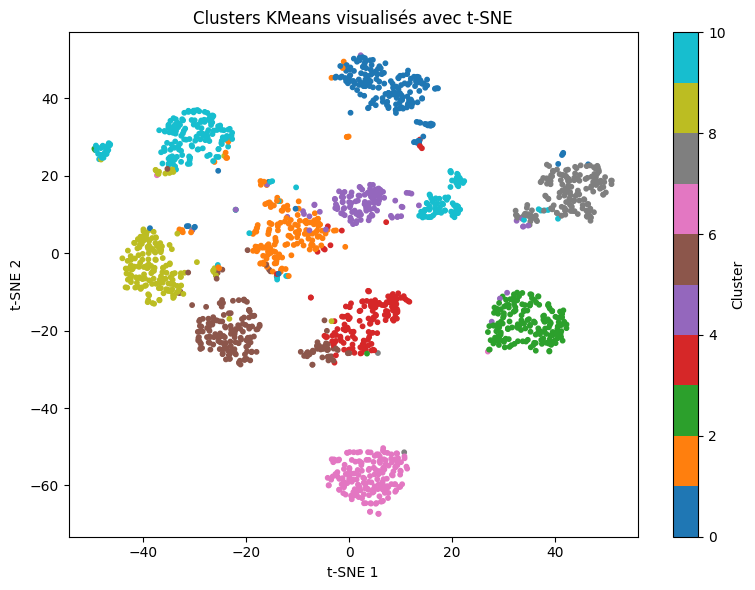

In [19]:
from sklearn.manifold import TSNE

# 6. Visualisation avec t-SNE
# Reprise de la meilleure configuration
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Réduction de dimension non linéaire
tsne = TSNE(n_components=2, random_state=0, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(X_scaled)

# Appliquer le meilleur KMeans sur les données transformées (sans PCA ici)
kmeans_tsne = KMeans(
    n_clusters=int(best_config.n_clusters),
    init=best_config.init,
    n_init=int(best_config.n_init),
    random_state=0
)
labels_tsne = kmeans_tsne.fit_predict(X_scaled)

# Visualisation t-SNE
plt.figure(figsize=(8, 6))
scatter_tsne = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels_tsne, cmap='tab10', s=10)
plt.title("Clusters KMeans visualisés avec t-SNE")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.colorbar(scatter_tsne, label="Cluster")
plt.tight_layout()
plt.show()
